# Performance & Risk Measurement

## Imports

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [100]:
import empyrical as emp
import pyfolio as pf
from alphalens.performance import create_pyfolio_input
import matplotlib.pyplot as plt
import alphalens
from pathlib import Path
import numpy as np
import pandas as pd
from pandas.tseries.offsets import BDay
import pandas_market_calendars as mcal
from statsmodels.graphics.tsaplots import plot_acf, acf

In [11]:
%matplotlib inline
plt.style.use('fivethirtyeight')

In [12]:
ASSETS_HDF = '../00_data/assets.h5'
FACTOR_HDF = '../01_alpha_factors/momentum_factor.h5'

# Get data

## Momentum Factor

In [15]:
months = 18
with pd.HDFStore(FACTOR_HDF) as store:
    factor_data = store[f'/momentum_overlay/factor_data/{months}/sp500']

In [16]:
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 822184 entries, (1989-06-30 00:00:00, ADBE) to (2016-12-28 00:00:00, ZION)
Data columns (total 6 columns):
63D                822184 non-null float64
126D               822184 non-null float64
189D               822184 non-null float64
252D               822184 non-null float64
factor             822184 non-null float64
factor_quantile    822184 non-null int64
dtypes: float64(5), int64(1)
memory usage: 41.2+ MB


In [17]:
factor_data.describe()

,63D,126D,189D,252D,factor,factor_quantile
count,822184.000000,822184.000000,822184.000000,822184.000000,822184.000000,822184.000000
mean,0.055426,0.111867,0.171390,0.234855,0.550136,2.996631
std,0.237461,0.367049,0.505211,0.645292,1.193526,1.420029
min,-0.986083,-0.989686,-0.992073,-0.992033,-0.994602,1.000000
25%,-0.061766,-0.068586,-0.069456,-0.065105,-0.173781,2.000000
50%,0.043632,0.081771,0.118160,0.155607,0.486220,3.000000
75%,0.150039,0.239048,0.318710,0.400149,0.932151,4.000000
max,10.809239,18.442293,24.789474,41.977665,44.401102,5.000000


## Reversal Factor

In [149]:
idx = pd.IndexSlice

In [203]:
short_term = 10
long_term = 50
with pd.HDFStore(FACTOR_HDF) as store:
    factor_data = store[f'crossing_ma/{short_term}/{long_term}/sp500/factor_data']

In [208]:
factor_data.head().reset_index().to_csv('factor_data.csv')

## Benchmark

In [204]:
holding_periods = [int(c[:-1]) for c in factor_data.columns if c.endswith('DeprecationWarning')]

In [284]:
def get_sp500(start=2010, end=2017):
    with pd.HDFStore(ASSETS_HDF) as store:
        sp500 = store['sp500/prices'].close.loc[str(start):str(end)]
        return sp500.to_frame('sp500')


def get_sp500_ret(start=2010, end=2017, fw=1):
    return get_sp500(start, end).pct_change(periods=fw)


def get_sp500_fw(start=2010, end=2017, periods=(1, 5, 10)):
    sp500 = get_sp500(start, end).resample('D').ffill()
    df = pd.concat([(sp500
                     .pct_change(periods=fw)
                     .shift(-fw)
                     .squeeze()
                     .to_frame(f'{fw}D')) for fw in periods], axis=1)
    return df.dropna()


def get_benchmark(factor_data, start=2013, periods=holding_periods):
    factor_dates = factor_data.index.get_level_values('date').unique()
    last = (factor_dates.max() + BDay(max(holding_periods))).year + 1
    return get_sp500_fw(start=start, end=last, periods=periods).reindex(factor_dates)

In [285]:
sp500 = get_sp500(start=2000).squeeze().pct_change().dropna().to_frame('sp500')
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4527 entries, 2000-01-04 to 2017-12-29
Data columns (total 1 columns):
sp500    4527 non-null float64
dtypes: float64(1)
memory usage: 70.7 KB


# Create Portfolio from Factor Signals

## Create & Store

In [154]:
returns, positions, benchmark = create_pyfolio_input(factor_data,
                                                     period='1D',
                                                     capital=100000,
                                                     long_short=False,
                                                     group_neutral=False,
                                                     equal_weight=False,
                                                     quantiles=[1, 5],
                                                     groups=None,
                                                     benchmark_period='1D')

In [209]:
short_term = 10
long_term = 50
which = 'sp500'
key = f'mean_reversal/{short_term}/{long_term}/{which}/'
with pd.HDFStore('risk_metrics.h5') as store:
    store.put(key + 'returns', returns)
    store.put(key + 'positions', positions)
    store.put(key + 'benchmark', benchmark)

## Load pyfolio data 

In [351]:
def mean_reversal_pyfolio(which='sp500', short_term=10, long_term=50):
    key = f'mean_reversal/{short_term}/{long_term}/{which}/'
    with pd.HDFStore('risk_metrics.h5') as store:
        returns = store[key + 'returns']
        positions = store[key + 'positions']
        benchmark = store[key + 'benchmark']
    return returns, positions, benchmark

In [352]:
returns, positions, benchmark = mean_reversal_pyfolio()

In [326]:
# def momentum_pyfolio(which='sp500', lookback=18, holding_period=189, long_short=False, top=False, start=2013, end=2016):
#     key = f'{which}/{lookback}/{holding_period}/{int(long_short)}/{int(top)}/'
#     with pd.HDFStore('risk_metrics.h5') as store:
#         returns = store[key + 'returns'].loc[str(start): str(end)]
#         positions = store[key + 'positions'].loc[str(start): str(end)]
#         benchmark = store[key + 'benchmark'].loc[str(start): str(end)]
#     return returns, positions, benchmark

# returns, positions, benchmark = momentum_pyfolio()

In [353]:
start, end = returns.index[0], returns.index[-1]

### Adjust timing to market calendar

In [354]:
nyse = mcal.get_calendar('NYSE')
schedule = nyse.schedule(start_date=start, end_date=end)
trading_dates = mcal.date_range(schedule, frequency='1D').date

In [355]:
sp500 = get_sp500(start=2000).squeeze().pct_change().loc[start:end].to_frame('sp500')

In [356]:
returns = returns.loc[trading_dates]
positions = positions.loc[trading_dates]
benchmark = benchmark.loc[trading_dates]
sp500 = sp500.loc[trading_dates]

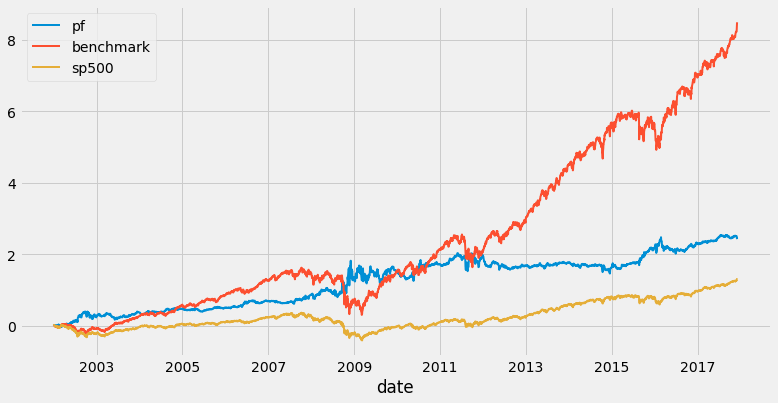

In [357]:
ret = pd.concat([returns.to_frame('pf'), benchmark.to_frame('benchmark'), sp500], axis=1).fillna(0)
ret.add(1).cumprod().sub(1).plot(figsize=(12,6), lw=2);

### Long-Short Positions

In [290]:
pf_positions = positions.drop('cash', axis=1).loc[trading_dates]
long = pf_positions.where(positions > 0)
short = pf_positions.where(positions < 0)

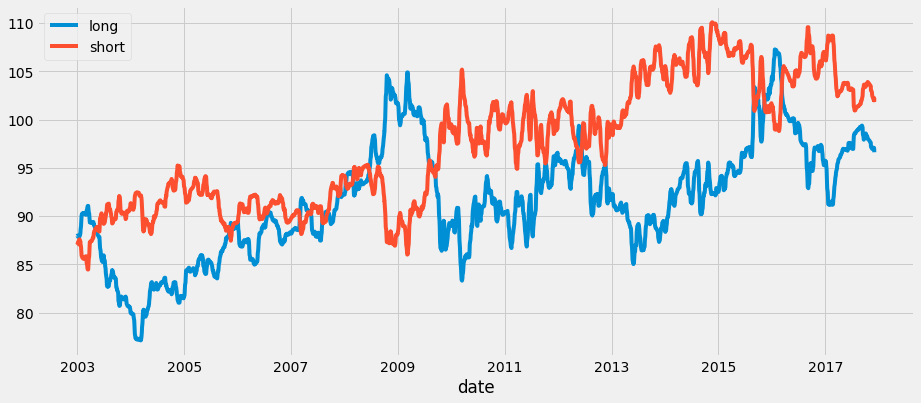

In [291]:
pd.concat([long.count(1).to_frame('long'), short.count(1).to_frame('short')], axis=1).rolling(252).mean().plot(figsize=(14, 6));

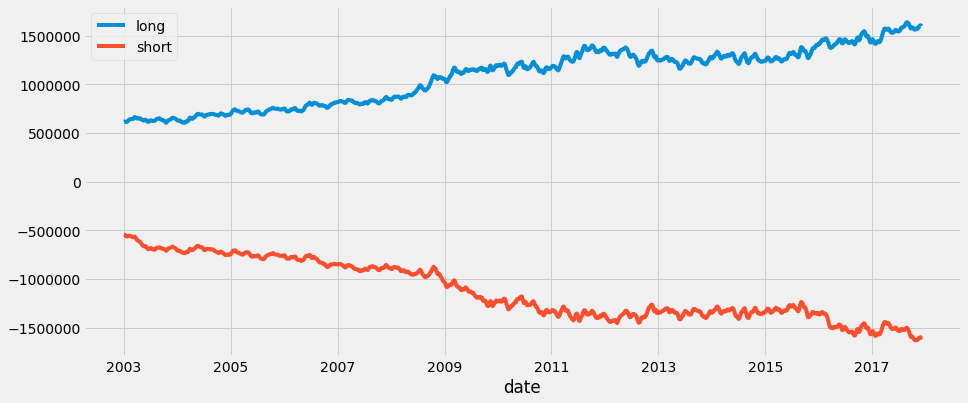

In [292]:
pd.concat([long.sum(1).to_frame('long'), short.sum(1).to_frame('short')], axis=1).rolling(252).mean().plot(figsize=(14, 6));

# Pyfolio Metrics

## Overview

### Empyrical

In [21]:
[d for d in dir(emp) if not d.startswith('_')]

['DAILY',
 'MONTHLY',
 'WEEKLY',
 'YEARLY',
 'aggregate_returns',
 'alpha',
 'alpha_aligned',
 'alpha_beta',
 'alpha_beta_aligned',
 'annual_return',
 'annual_volatility',
 'beta',
 'beta_aligned',
 'cagr',
 'calmar_ratio',
 'capture',
 'compute_exposures',
 'conditional_value_at_risk',
 'cum_returns',
 'cum_returns_final',
 'deprecate',
 'down_alpha_beta',
 'down_capture',
 'downside_risk',
 'excess_sharpe',
 'max_drawdown',
 'omega_ratio',
 'perf_attrib',
 'periods',
 'roll_alpha',
 'roll_alpha_aligned',
 'roll_alpha_beta',
 'roll_alpha_beta_aligned',
 'roll_annual_volatility',
 'roll_beta',
 'roll_beta_aligned',
 'roll_down_capture',
 'roll_max_drawdown',
 'roll_sharpe_ratio',
 'roll_sortino_ratio',
 'roll_up_capture',
 'roll_up_down_capture',
 'sharpe_ratio',
 'simple_returns',
 'sortino_ratio',
 'stability_of_timeseries',
 'stats',
 'tail_ratio',
 'up_alpha_beta',
 'up_capture',
 'up_down_capture',
 'utils',
 'value_at_risk']

### Pyfolio

Built-in plotting functions:
- plot_annual_returns
- plot_daily_returns_similarity
- plot_daily_turnover_hist
- plot_daily_volume
- plot_drawdown_periods
- plot_drawdown_underwater
- plot_exposures
- plot_gross_leverage
- plot_holdings
- plot_monthly_returns_dist
- plot_monthly_returns_heatmap
- plot_return_quantiles
- plot_rolling_beta
- plot_rolling_fama_french
- plot_rolling_returns
- plot_rolling_sharpe
- plot_sector_allocations
- plot_slippage_sensitivity
- plot_slippage_sweep
- plot_turnover
- show_and_plot_top_positions

Tearsheet Functions:

- create_bayesian_tear_sheet
- create_capacity_tear_sheet
- create_full_tear_sheet
- create_interesting_times_tear_sheet
- create_perf_attrib_tear_sheet
- create_position_tear_sheet
- create_returns_tear_sheet
- create_risk_tear_sheet
- create_round_trip_tear_sheet
- create_simple_tear_sheet
- create_txn_tear_sheet

In [101]:
[f for f in dir(pf) if not f.startswith('_')]

['APPROX_BDAYS_PER_MONTH',
 'FACTOR_PARTITIONS',
 'FigureCanvasAgg',
 'FuncFormatter',
 'MM_DISPLAY_UNIT',
 'Markdown',
 'OrderedDict',
 'STAT_FUNCS_PCT',
 'axes_style',
 'capacity',
 'create_bayesian_tear_sheet',
 'create_capacity_tear_sheet',
 'create_full_tear_sheet',
 'create_interesting_times_tear_sheet',
 'create_perf_attrib_tear_sheet',
 'create_position_tear_sheet',
 'create_returns_tear_sheet',
 'create_risk_tear_sheet',
 'create_round_trip_tear_sheet',
 'create_simple_tear_sheet',
 'create_txn_tear_sheet',
 'customize',
 'datetime',
 'deprecate',
 'display',
 'division',
 'ep',
 'figure',
 'gridspec',
 'have_bayesian',
 'interesting_periods',
 'matplotlib',
 'np',
 'patches',
 'pd',
 'perf_attrib',
 'plot_annual_returns',
 'plot_capacity_sweep',
 'plot_cones',
 'plot_daily_turnover_hist',
 'plot_daily_volume',
 'plot_drawdown_periods',
 'plot_drawdown_underwater',
 'plot_exposures',
 'plot_gross_leverage',
 'plot_holdings',
 'plot_long_short_holdings',
 'plot_max_median_posit

In [102]:
[f for f in dir(pf.timeseries) if not f.startswith('_')]

['APPROX_BDAYS_PER_MONTH',
 'APPROX_BDAYS_PER_YEAR',
 'DAILY',
 'DEPRECATION_WARNING',
 'FACTOR_STAT_FUNCS',
 'OrderedDict',
 'PERIODS',
 'SIMPLE_STAT_FUNCS',
 'STAT_FUNC_NAMES',
 'aggregate_returns',
 'alpha',
 'alpha_beta',
 'annual_return',
 'annual_volatility',
 'beta',
 'calc_bootstrap',
 'calc_distribution_stats',
 'calmar_ratio',
 'common_sense_ratio',
 'cum_returns',
 'deprecated',
 'division',
 'downside_risk',
 'ep',
 'extract_interesting_date_ranges',
 'forecast_cone_bootstrap',
 'gen_drawdown_table',
 'get_max_drawdown',
 'get_max_drawdown_underwater',
 'get_top_drawdowns',
 'get_turnover',
 'gross_lev',
 'linear_model',
 'max_drawdown',
 'normalize',
 'np',
 'omega_ratio',
 'partial',
 'pd',
 'perf_stats',
 'perf_stats_bootstrap',
 'rolling_beta',
 'rolling_regression',
 'rolling_sharpe',
 'rolling_volatility',
 'sharpe_ratio',
 'simulate_paths',
 'sortino_ratio',
 'sp',
 'stability_of_timeseries',
 'stats',
 'summarize_paths',
 'tail_ratio',
 'value_at_risk',
 'var_cov_va

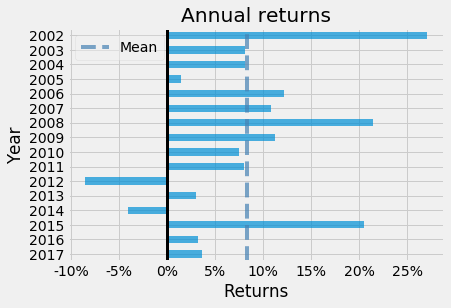

In [360]:
pf.plot_annual_returns(returns=returns)

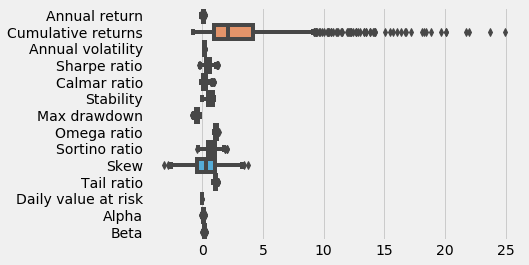

In [361]:
pf.plot_perf_stats(returns=returns, factor_returns=sp500)

In [367]:
pf.timeseries.perf_stats(returns=returns, factor_returns=sp500).to_csv('perf_stats.csv')

![title](../03_risk_mgmt/efficient_frontier/ef.png)

In [ ]:
interesting_times = pf.timeseries.extract_interesting_date_ranges(returns=returns)
interesting_times['Lehmann'].to_frame('pf').join(sp500).add(1).cumprod().sub(1).plot(lw=2, figsize=(14, 6));

## Sharpe Ratio

In [293]:
import pandas_datareader.data as web

rf = web.DataReader('DGS3', 'fred', start=start, end=end).squeeze().div(252)
rf.head()

DATE
2002-01-02    0.014881
2002-01-03    0.014722
2002-01-04    0.014762
2002-01-07    0.014325
2002-01-08    0.014286
Name: DGS3, dtype: float64

In [294]:
rf.describe()

count    3985.000000
mean        0.007935
std         0.005590
min         0.001111
25%         0.003611
50%         0.005913
75%         0.011786
max         0.020873
Name: DGS3, dtype: float64

In [302]:
(returns.mean() / returns.std()) * np.sqrt(252)

0.5005300386569191

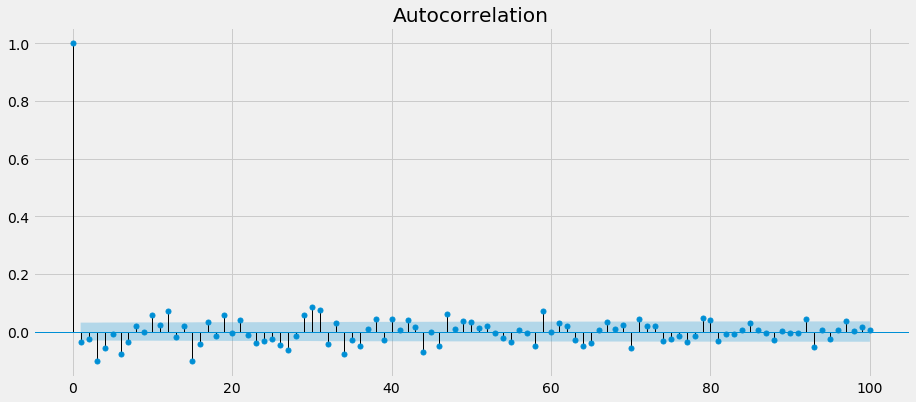

In [305]:
fig, ax = plt.subplots(figsize=(14, 6))
plot_acf(returns, ax=ax, lags=100, lw=1);

In [276]:
pf.timeseries.sharpe_ratio(returns)

0.5005300386569191

In [308]:
emp.sharpe_ratio(returns=returns, risk_free=0)

0.5005300386569191

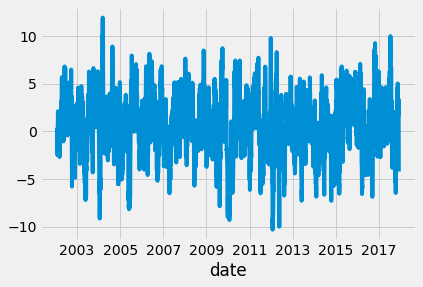

In [307]:
emp.roll_sharpe_ratio(returns, window=21).plot()

### Alpha-Beta

In [309]:
alpha, beta = emp.alpha_beta(returns=returns, factor_returns=sp500)

In [310]:
alpha, beta

(0.08372782815796737, 0.1688611523010979)

### CVaR

In [311]:
emp.conditional_value_at_risk(returns)

-0.026486369811343363

In [312]:
emp.max_drawdown(returns)

-0.2656864082579067

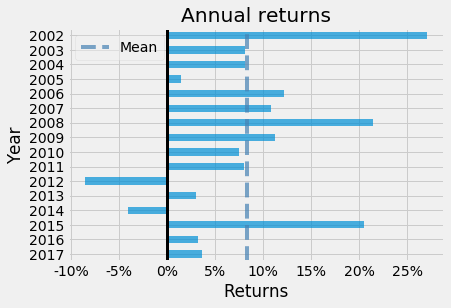

In [313]:
pf.plot_annual_returns(returns)

In [315]:
returns.index = pd.to_datetime(returns.index)

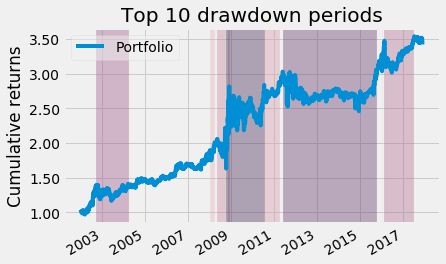

In [316]:
pf.plot_drawdown_periods(returns)

In [ ]:
pf.timeseries.

In [332]:
pf.create_returns_tear_sheet(returns, live_start_date=pd.to_datetime('2016-1-1'), benchmark_rets=sp500)

TypeError: Cannot compare type 'Timestamp' with type 'date'

# PyFolio Tearsheet

In [337]:
returns.index = pd.to_datetime(returns.index)
sp500.index = pd.to_datetime(sp500.index)

Start date,2002-01-02
End date,2017-12-01
Total months,190
,Backtest
Annual return,8.0%
Cumulative returns,242.3%
Annual volatility,19.1%
Sharpe ratio,0.50
Calmar ratio,0.30
Stability,0.91
Max drawdown,-26.6%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,26.57,2008-10-01,2008-10-09,2008-11-05,26
1,22.54,2008-12-02,2009-04-17,2010-07-19,425
2,18.85,2011-06-01,2014-12-15,2015-10-02,1133
3,18.62,2008-11-17,2008-11-20,2008-11-26,8
4,16.51,2002-09-26,2003-06-05,2004-03-12,382


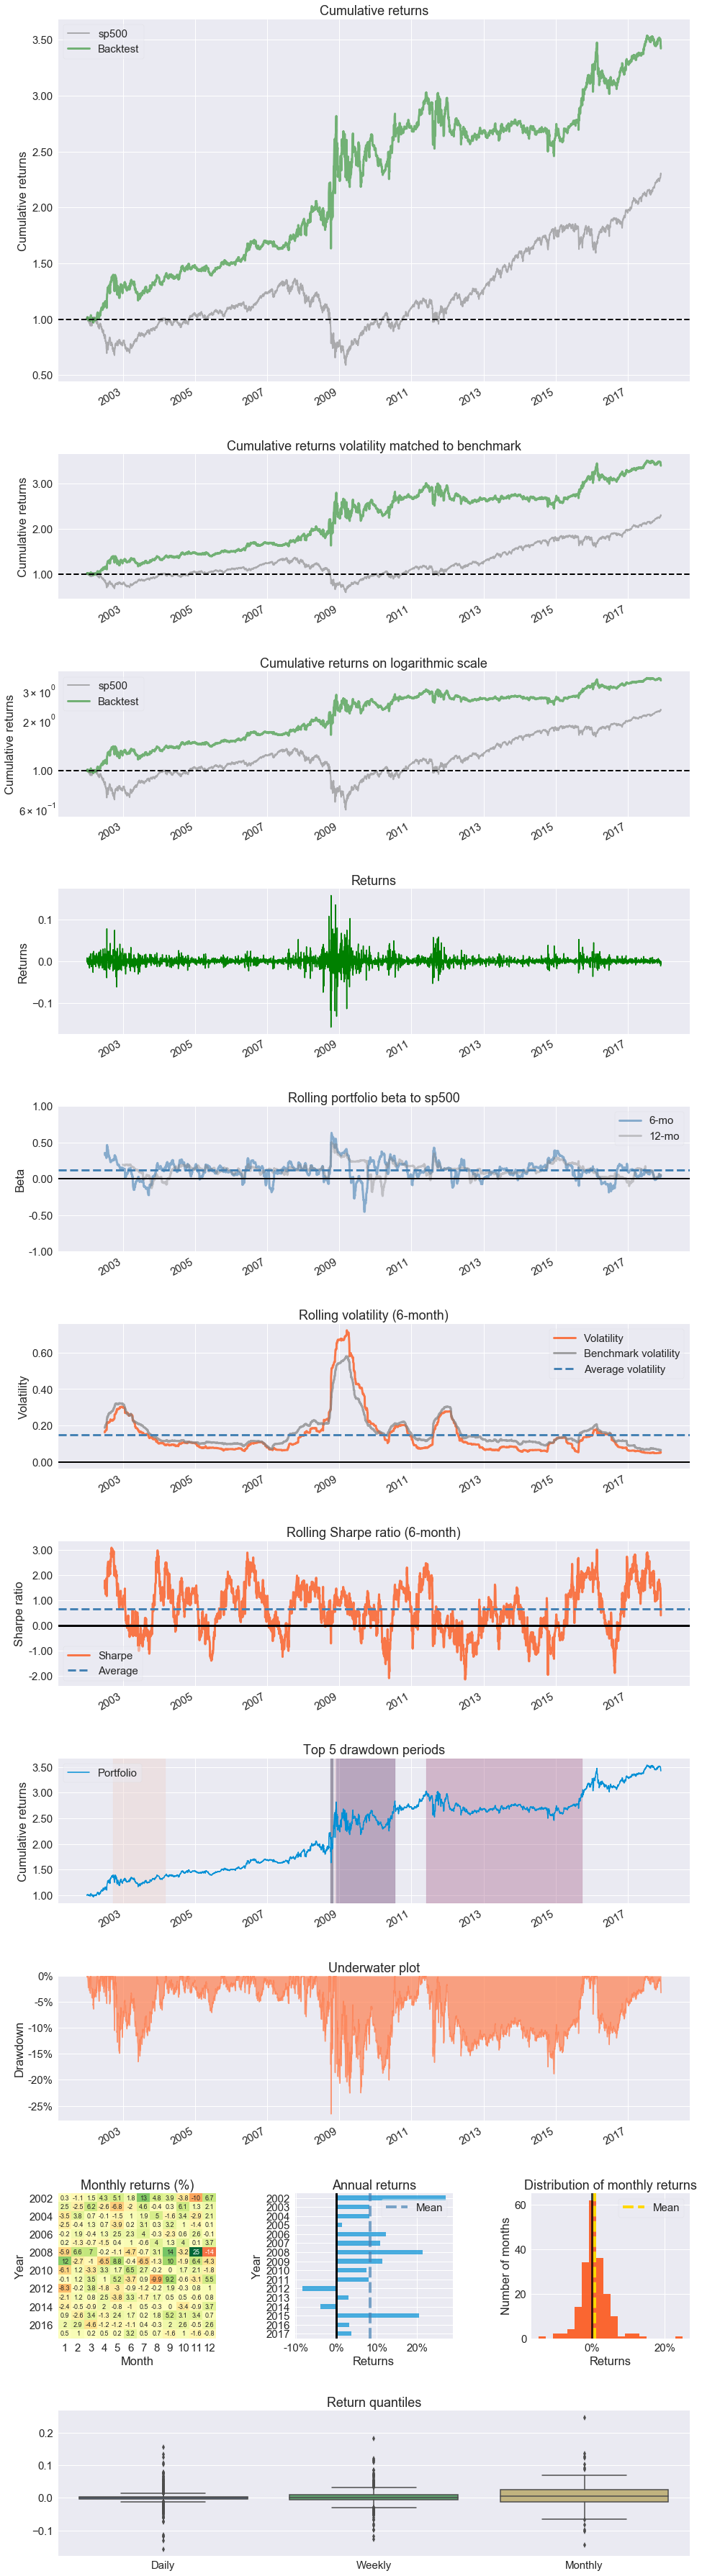

Stress Events,mean,min,max
Lehmann,0.42%,-2.33%,10.75%
US downgrade/European Debt Crisis,0.15%,-5.34%,5.68%
Fukushima,0.10%,-0.82%,1.24%
US Housing,-0.12%,-3.10%,1.85%
EZB IR Event,0.00%,-1.16%,1.30%
Aug07,0.18%,-2.05%,2.91%
Mar08,0.22%,-4.14%,3.24%
Sept08,0.67%,-2.33%,10.75%
2009Q1,0.26%,-4.96%,6.69%
2009Q2,0.06%,-11.38%,10.21%


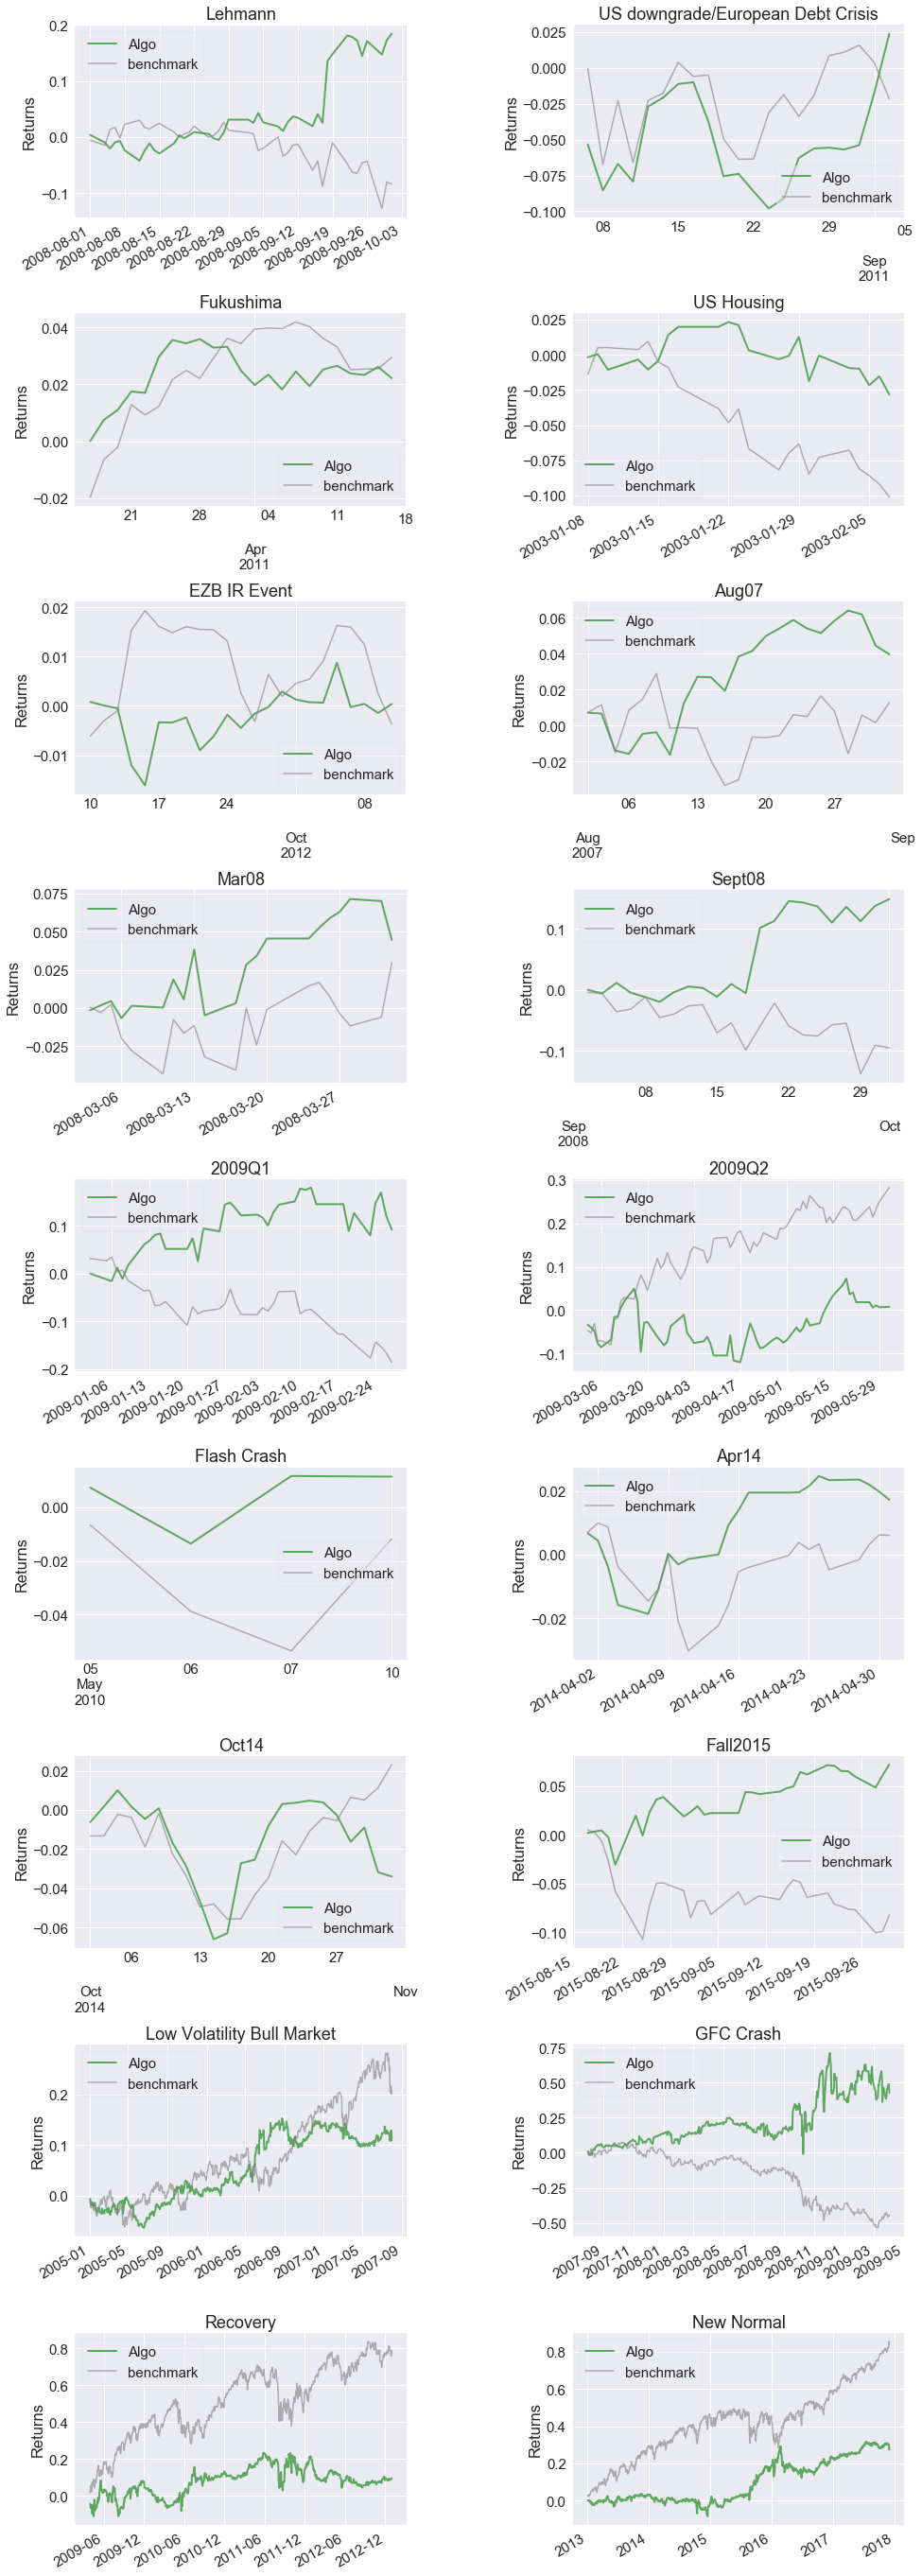

Top 10 long positions of all time,max
asset,
AAL,9.07%
AIG,7.68%
PWR,7.57%
REGN,7.38%
PNR,6.82%
SBAC,6.49%
VRSN,5.99%
GGP,5.29%
AES,5.18%


Top 10 short positions of all time,max
asset,
EVHC,-11.12%
GGP,-9.52%
REGN,-7.22%
AIG,-7.18%
ALGN,-6.85%
WMB,-6.37%
AES,-6.09%
SBAC,-5.76%
ILMN,-5.39%


Top 10 positions of all time,max
asset,
EVHC,11.12%
GGP,9.52%
AAL,9.07%
AIG,7.68%
PWR,7.57%
REGN,7.38%
ALGN,6.85%
PNR,6.82%
SBAC,6.49%


All positions ever held,max
asset,
EVHC,11.12%
GGP,9.52%
AAL,9.07%
AIG,7.68%
PWR,7.57%
REGN,7.38%
ALGN,6.85%
PNR,6.82%
SBAC,6.49%


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

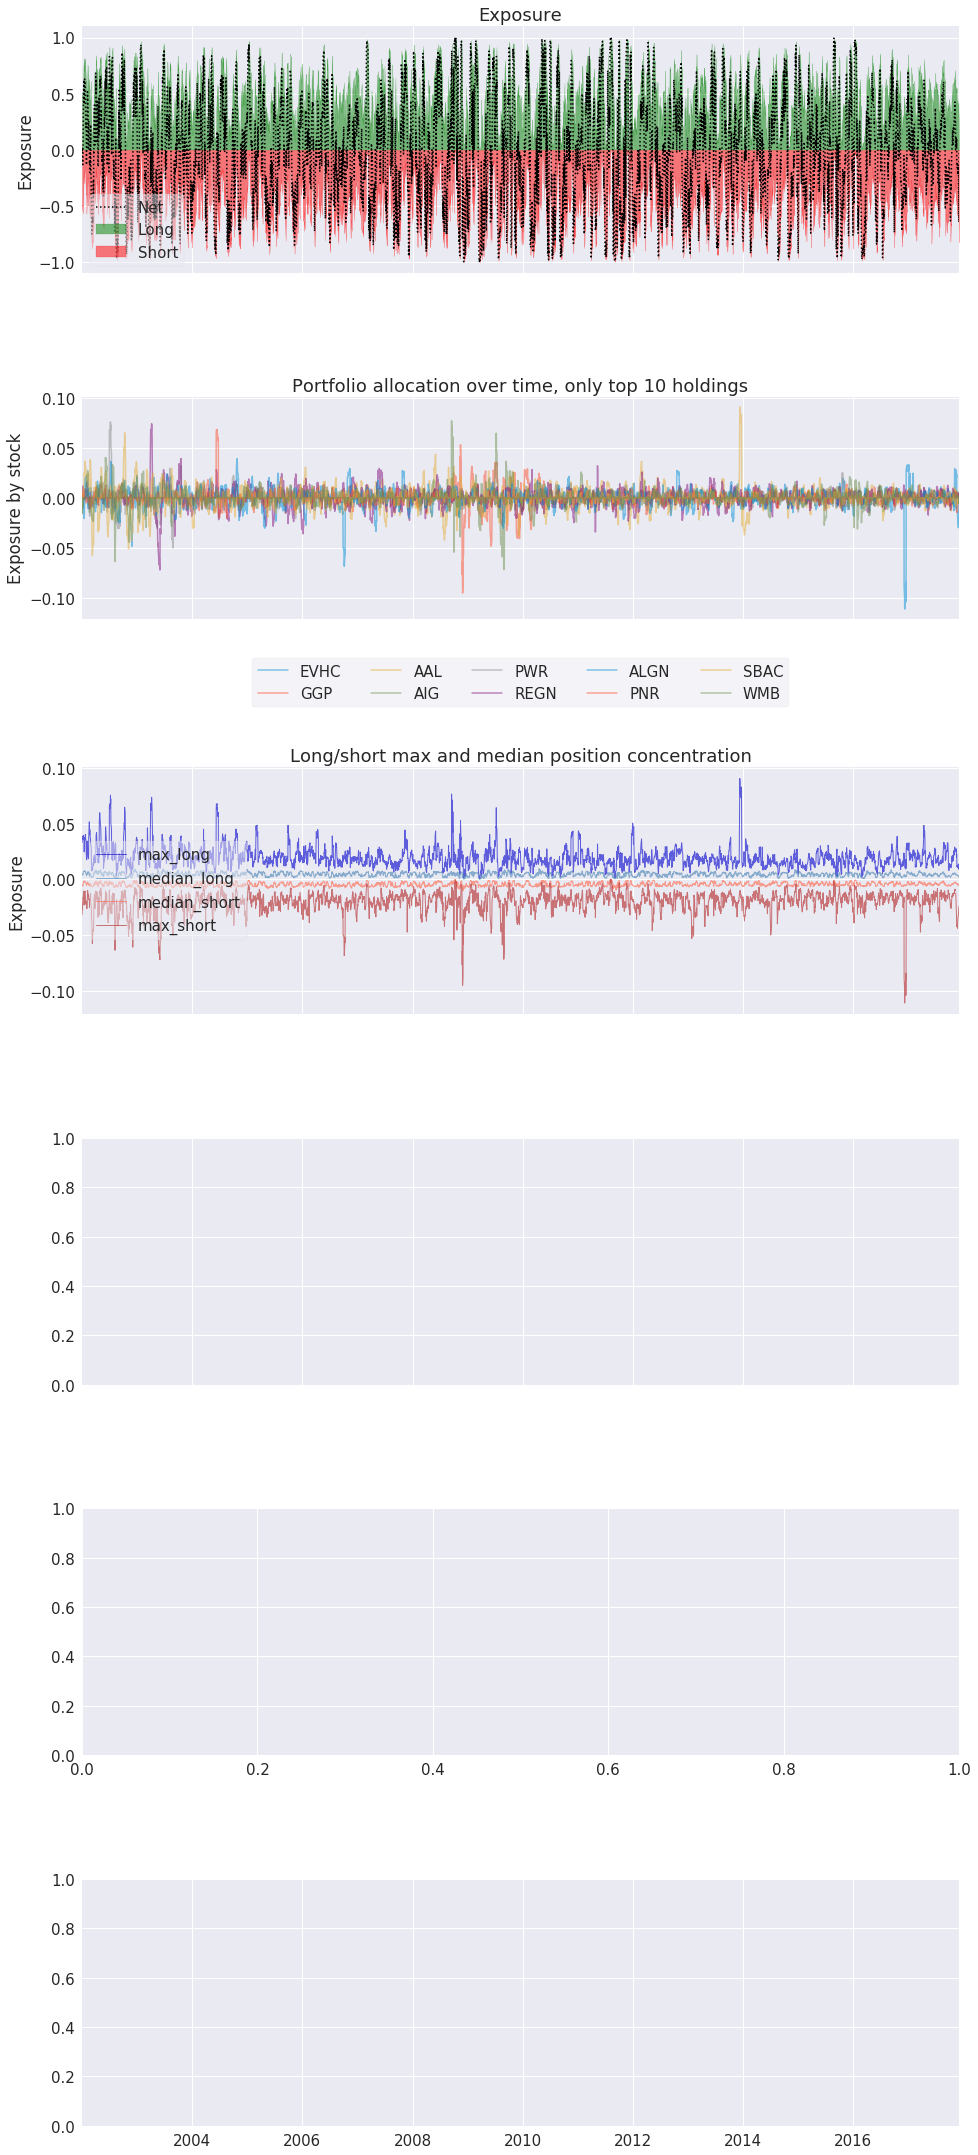

In [338]:
pf.create_full_tear_sheet(returns=returns,
                          positions=positions,
                          benchmark_rets=sp500.squeeze())